In [39]:
import sys
sys.path.insert(0, '../../src')
from models.IDEAL import IDEAL
from utils import visualization as vis
from utils import preprocession as prep
from utils.metrics import compute_metric

import WassersteinTSNE as WT


import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.spatial import distance
from scipy.optimize import minimize
from tqdm.notebook import tqdm

tqdm.pandas()

## Load Smartvote Data

In [40]:
folder_name = 'Smartvote'
data_name = 'Binary'

folder_path = f"../../data/{folder_name}"
data_path = f"../../data/{folder_name}/{data_name}"
output_path = f"../../embeddings/IDEAL/{folder_name}"

In [41]:
test_users = pd.read_csv(f'{folder_path}/test_candidates.csv', index_col=0)
train_users = pd.read_csv(f'{folder_path}/train_candidates.csv', index_col=0)
train_users

index  party    color  party_id  yays  nays
0         6  Grüne  #008000         4    48    27
1        17    FDP  #4169E1         2    37    38
2        40    FDP  #4169E1         2    42    33
3        41  Grüne  #008000         4    44    31
4        44    glp  #32CD32         6    44    31
...     ...    ...      ...       ...   ...   ...
1905   4643  Grüne  #008000         4    43    32
1906   4644  Grüne  #008000         4    44    31
1907   4645     SP  #FF0000         1    49    26
1909   4648    CVP  #FFA500         3    48    27
1910   4659    CVP  #FFA500         3    48    27

[1622 rows x 6 columns]

In [42]:
test_reactions = prep.load_all('test_reactions', data_path)
train_reactions = prep.load_all('train_reactions', data_path)
train_reactions.keys()

dict_keys([60, 70, 10, 0, 20, 30, 40, 80, 90, 50])

In [43]:
betabar   = prep.load_all('betabar', directory=output_path)
xbar = prep.load_all('xbar', directory=output_path)
betabar.keys()

dict_keys([10, 70, 60, 50, 90, 80, 40, 30, 20, 0])

## Check IDEAL Results

In [51]:
p = 90
betabar[p]

Discrimination D1  Discrimination D2  Difficulty
0            0.805342           0.430309   -0.175142
1            0.367866           0.629648    0.973394
2           -0.101158           2.068969    1.862595
3           -1.158674          -1.981196   -0.873977
4           -0.156372          -0.958923   -0.797265
..                ...                ...         ...
70          -0.709464          -0.576238   -1.407249
71          -1.397301          -0.803407    0.444161
72           0.649044           1.200401    1.475299
73          -1.055822          -0.684116   -0.525805
74          -4.965751           5.812886    7.369453

[75 rows x 3 columns]

In [52]:
xbar[p]

D1        D2
Legislator 1     0.244092 -0.501048
Legislator 2    -0.953732  1.168598
Legislator 3     1.006305  0.508580
Legislator 4    -1.563148  0.330007
Legislator 5     0.104369 -0.386542
...                   ...       ...
Legislator 1618 -0.324778 -0.768637
Legislator 1619 -1.046337 -0.624906
Legislator 1620 -0.761652  0.198703
Legislator 1621 -0.800088  0.425947
Legislator 1622 -0.096718 -0.428550

[1622 rows x 2 columns]

In [53]:
ideal = IDEAL(betabar[p], xbar[p], index=train_reactions[p].index, columns=train_reactions[p].columns)
ideal.train_embedding

x         y
0     0.244092 -0.501048
1    -0.953732  1.168598
2     1.006305  0.508580
3    -1.563148  0.330007
4     0.104369 -0.386542
...        ...       ...
1905 -0.324778 -0.768637
1906 -1.046337 -0.624906
1907 -0.761652  0.198703
1909 -0.800088  0.425947
1910 -0.096718 -0.428550

[1622 rows x 2 columns]

### Accuracy

In [54]:
predictions = ideal.predict(ideal.train_embedding.values)

_ = compute_metric(predictions, train_reactions[0], train_reactions[p].isna())


 Fit Accuracy: 0.8775761846045447
 Fit RMSE: 0.29191554975412004
 Imputation Accuracy: 0.7631736418365127
 Imputation RMSE: 0.4132951795012896



In [12]:
fit_results = pd.DataFrame(train_reactions[p].progress_apply(ideal.encode, axis=1, result_type='expand').values,
                           index=train_reactions[p].index, 
                           columns=['coord1D', 'coord2D', 'fit'])

fit_predictions = ideal.predict(fit_results.iloc[:,:2].values)

_ = compute_metric(fit_predictions, train_reactions[0], train_reactions[p].isna())

 Fit Accuracy: 0.8769596617932006
 Fit RMSE: 0.3159192959204527
 Imputation Accuracy: 0.7518223688982375
 Imputation RMSE: 0.4178202950490309



In [14]:
fit_results

coord1D   coord2D       fit
0     0.134209 -0.039181  0.819611
1     0.076127  0.454512  2.154176
2     0.356180  0.594333  0.626366
3    -0.505048 -0.277062  1.420643
4     0.000000  0.000000  0.994143
...        ...       ...       ...
1905 -0.120461 -0.175925  0.149592
1906 -1.186098 -0.721928  1.286560
1907 -0.101401 -0.020507  1.203290
1909 -0.483268  0.214664  1.377325
1910  0.000000  0.000000  0.904869

[1622 rows x 3 columns]

## Visualization

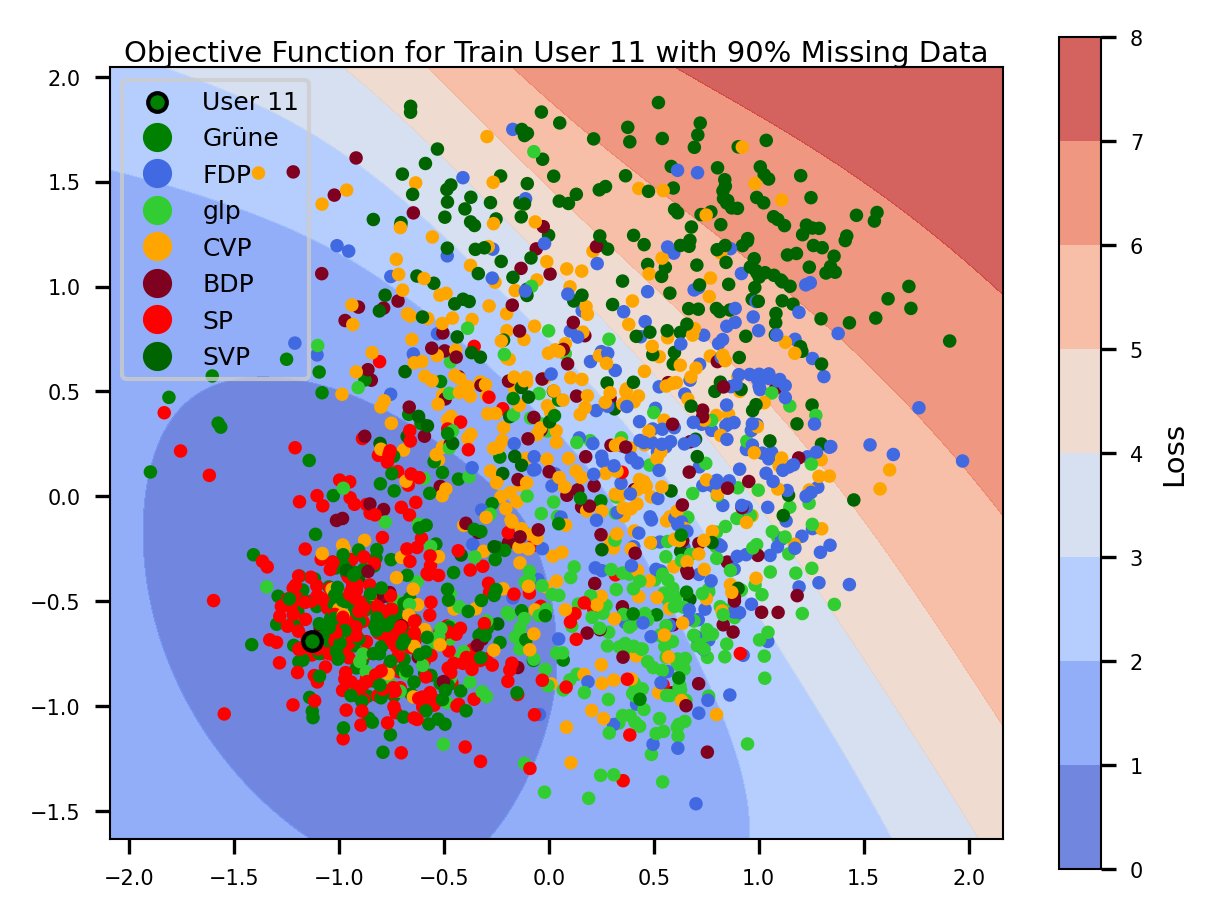

In [12]:
q = 4
n = 11
fig, ax = plt.subplots(figsize=(vis.textwidth,0.75*vis.textwidth))

ax = vis.plotEmbedding(ideal.train_embedding, n=n, ax=ax, s=5, c=train_users['color'],
                        highlight={'s':20,'lw':1, 'color':train_users.loc[n, 'color']})            
ax.set_title(f'Objective Function for Train User {n} with {p}% Missing Data')

vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name])

user = train_reactions[p].loc[n]
answers = user.loc[~user.isna()]
vis.plotObjective(ideal.objective, answers, r=200, ax=ax)
plt.show()

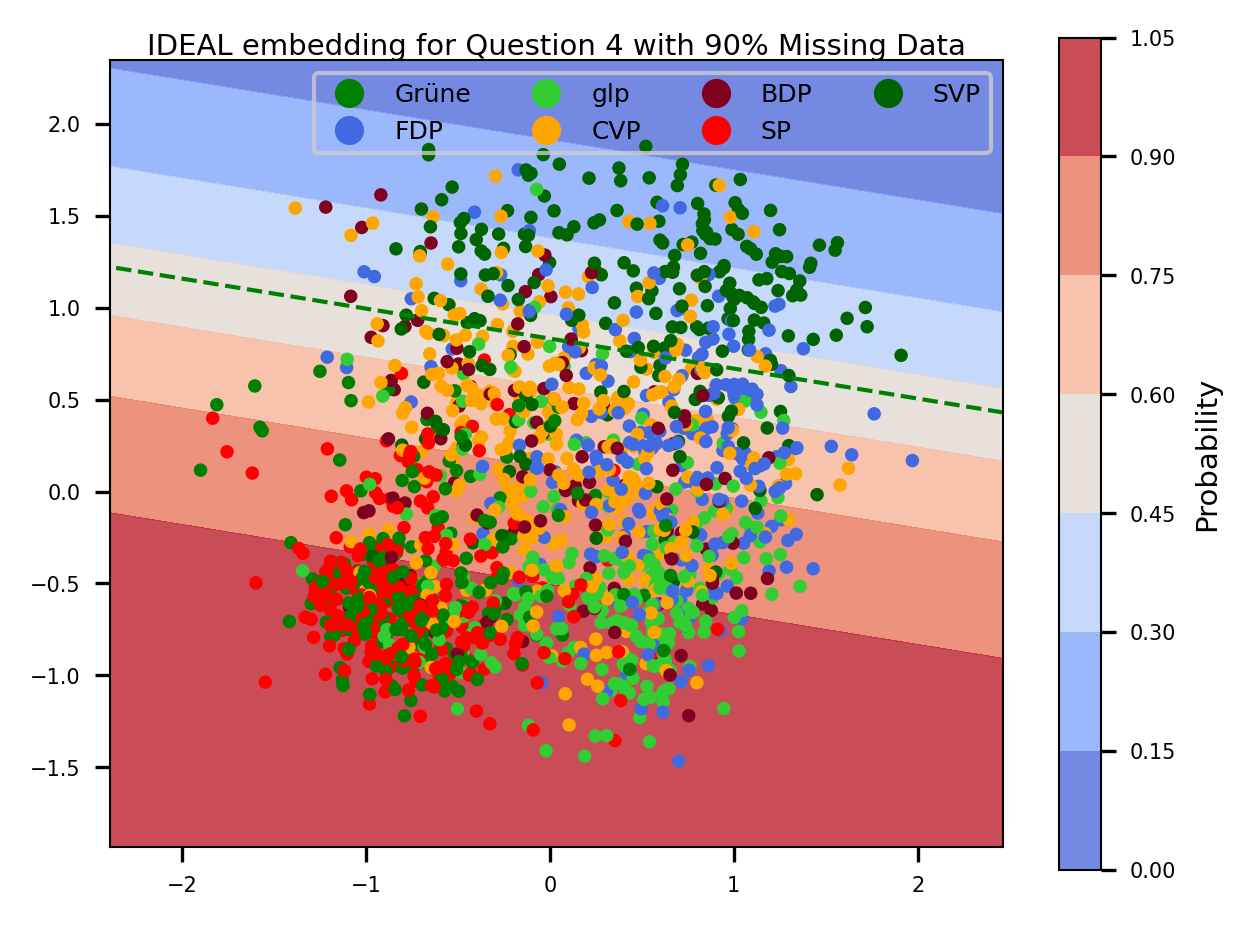

In [29]:
q = 4
fig, ax =  plt.subplots(figsize=(vis.textwidth,0.75*vis.textwidth))

ax = vis.plotEmbedding(ideal.train_embedding, ax=ax, s=5, c=train_users['color'])              
ax.set_title(f'IDEAL embedding for Question {q} with {p}% Missing Data')


vis.plotFeature(ideal.predict, q, d=0.3, ax=ax)
vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], ncols=4)

plt.show()

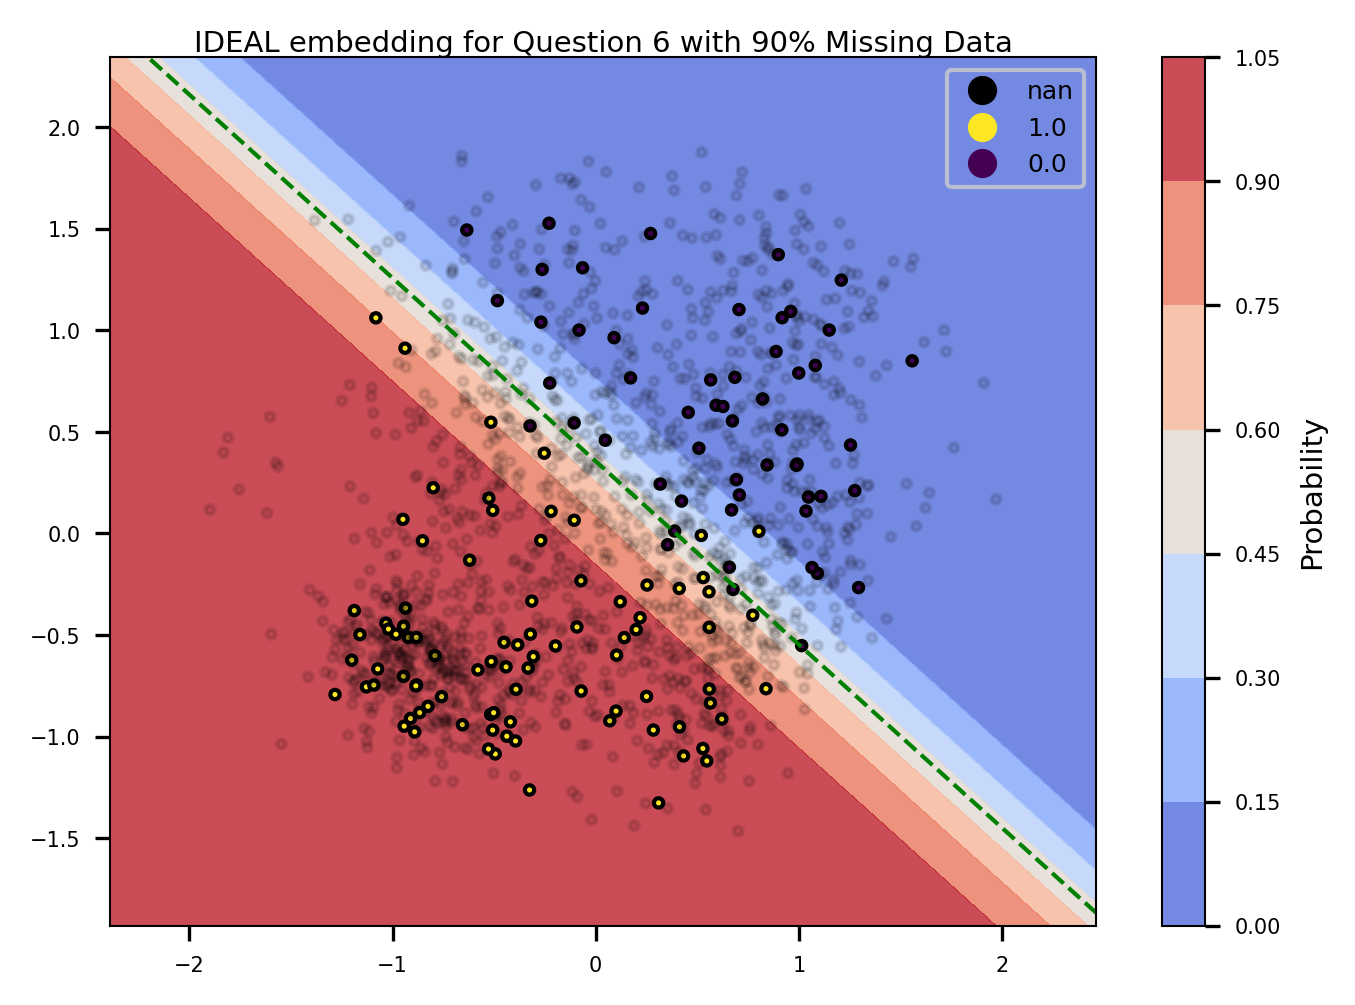

In [30]:
q = 6
fig, ax = plt.subplots(figsize=(vis.textwidth,0.7*vis.textwidth))

ax.set_title(f'IDEAL embedding for Question {q} with {p}% Missing Data')

answers = train_reactions[p].loc[:,str(q)]
colors = vis.hexColors(answers, vis.colormap)
alphas = [0.1 if c == '#000000' else 1 for c in colors]
ax = vis.plotEmbedding(ideal.train_embedding, ax=ax, s=5, c=colors, edgecolors='black', alpha=alphas)
         
vis.plotFeature(ideal.predict, q, d=0.3, ax=ax)
vis.extendLegend(ax, answers.unique(), lambda name: vis.hexColors([name], vis.colormap)[0])
fig.tight_layout()
plt.show()

#### Embed new users

In [32]:
test_reactions[p]

0    1    2   3    4    5   6    7    8   9  ...   65  66   67  68  \
5     NaN  NaN  NaN NaN  NaN  0.0 NaN  NaN  NaN NaN  ...  NaN NaN  NaN NaN   
9     1.0  NaN  1.0 NaN  NaN  NaN NaN  NaN  NaN NaN  ...  NaN NaN  NaN NaN   
12    NaN  NaN  NaN NaN  NaN  NaN NaN  NaN  NaN NaN  ...  NaN NaN  1.0 NaN   
16    NaN  NaN  NaN NaN  NaN  NaN NaN  0.0  NaN NaN  ...  NaN NaN  NaN NaN   
26    NaN  NaN  NaN NaN  NaN  NaN NaN  NaN  NaN NaN  ...  NaN NaN  NaN NaN   
...   ...  ...  ...  ..  ...  ...  ..  ...  ...  ..  ...  ...  ..  ...  ..   
1869  NaN  NaN  NaN NaN  NaN  NaN NaN  0.0  NaN NaN  ...  NaN NaN  NaN NaN   
1878  0.0  0.0  NaN NaN  NaN  NaN NaN  NaN  1.0 NaN  ...  NaN NaN  NaN NaN   
1881  NaN  NaN  NaN NaN  0.0  1.0 NaN  NaN  NaN NaN  ...  NaN NaN  NaN NaN   
1908  NaN  NaN  NaN NaN  NaN  0.0 NaN  NaN  NaN NaN  ...  1.0 NaN  NaN NaN   
1911  NaN  NaN  NaN NaN  NaN  NaN NaN  NaN  1.0 NaN  ...  NaN NaN  1.0 NaN   

       69   70   71  72  73   74  
5     0.0  NaN  NaN NaN NaN  0.0  
9     NaN  NaN  0.0 NaN NaN  NaN  
12    NaN  NaN  NaN NaN NaN  NaN  
16    NaN  NaN  NaN NaN NaN  0.0  
26    NaN  NaN  1.0 NaN NaN  NaN  
...   ...  ...  ...  ..  ..  ...  
1869  NaN  NaN  NaN NaN NaN  NaN  
1878  NaN  1.0  NaN NaN NaN  NaN  
1881  NaN  NaN  NaN NaN NaN  NaN  
1908  NaN  NaN  NaN NaN NaN  NaN  
1911  NaN  NaN  NaN NaN NaN  NaN  

[290 rows x 75 columns]

In [34]:
fit_results = pd.DataFrame(test_reactions[p].progress_apply(ideal.encode, axis=1, result_type='expand').values,
                           index=test_reactions[p].index, 
                           columns=['coord1D', 'coord2D', 'fit'])

fit_predictions = ideal.predict(fit_results.iloc[:,:2].values)

_ = compute_metric(fit_predictions, test_reactions[0], test_reactions[p].isna())

  0%|          | 0/290 [00:00<?, ?it/s]

 Fit Accuracy: 0.8625615763546798
 Fit RMSE: 0.3257360924096275
 Imputation Accuracy: 0.753448275862069
 Imputation RMSE: 0.4151992998088439



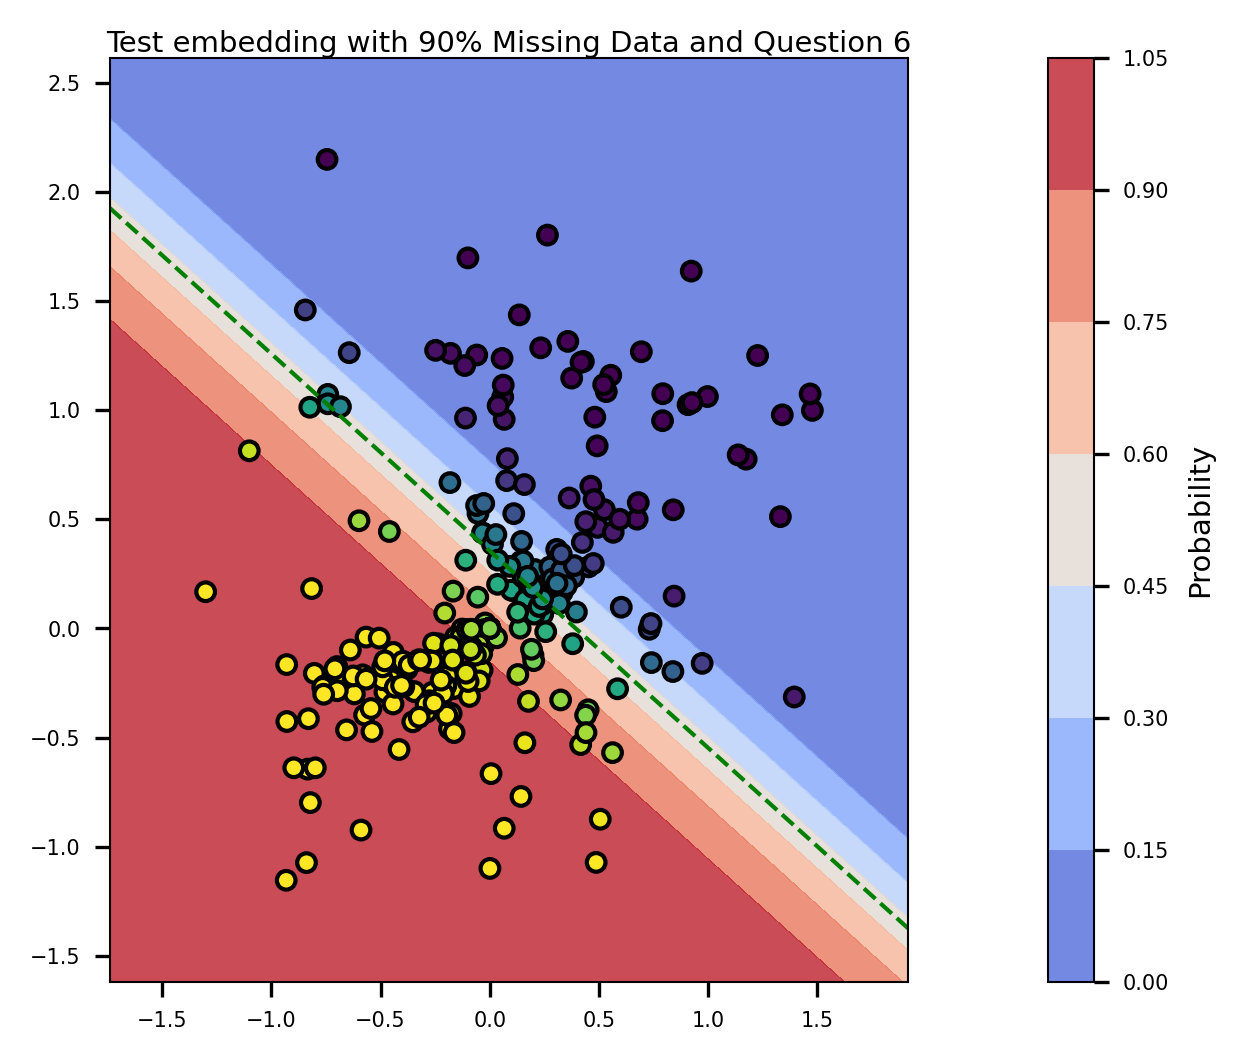

In [35]:
q = 6
fig, ax = plt.subplots(figsize=(12,4))

ax.set_title(f'Test embedding with {p}% Missing Data and Question {q}')

answers = fit_predictions[:,q]
colors = vis.hexColors(answers, vis.colormap)
alphas = [0.1 if c == '#000000' else 1 for c in colors]
ax = vis.plotEmbedding(fit_results, ax=ax, s=20, c=colors, edgecolors='black', alpha=alphas)   
         
vis.plotFeature(ideal.predict, q, d=0.3, ax=ax)
plt.show()

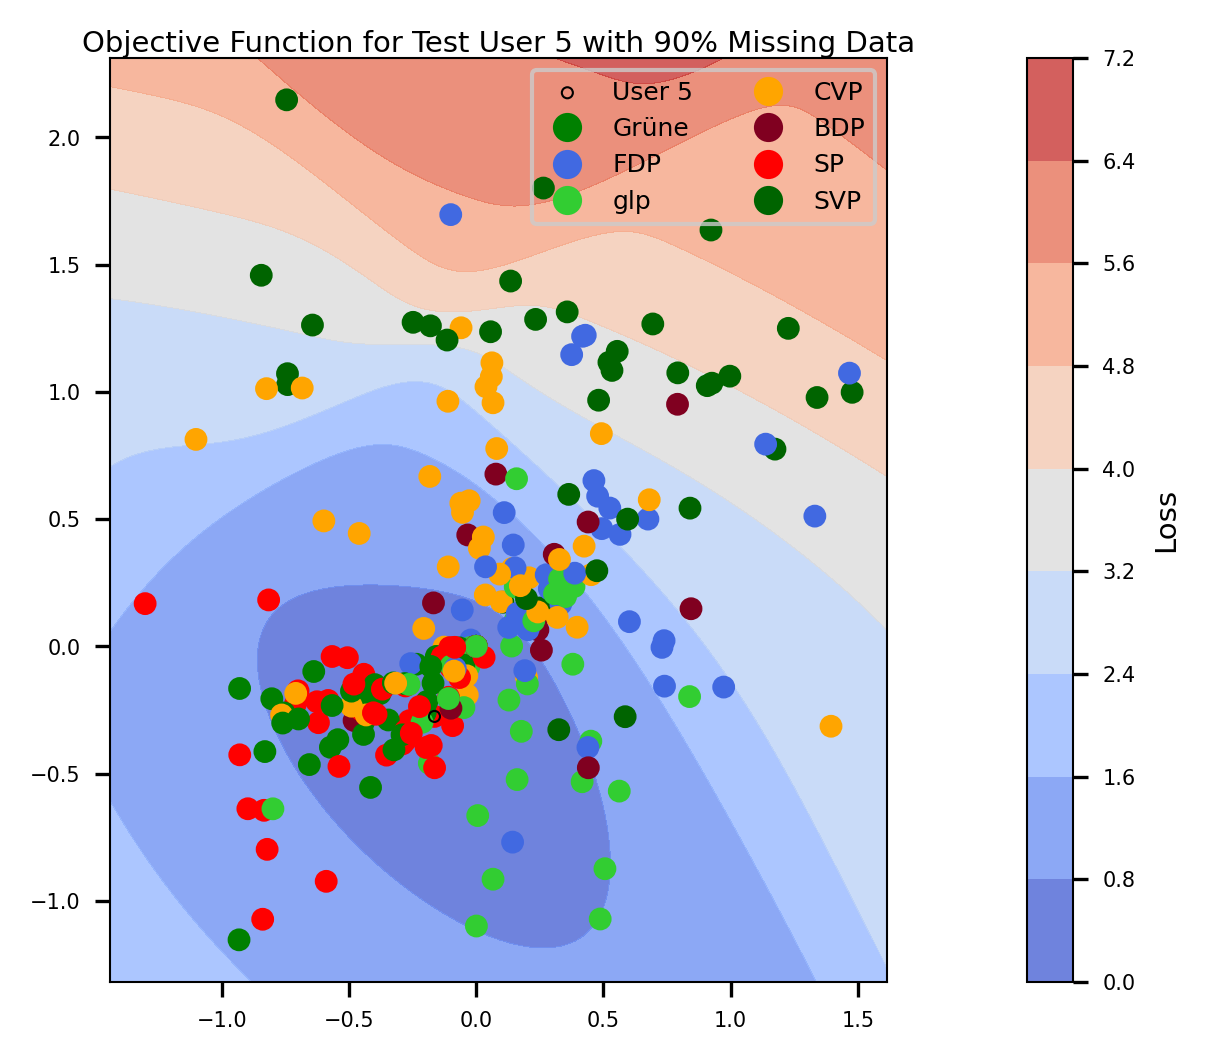

In [36]:
q = 4
n = 5
fig, ax = plt.subplots(figsize=(12,4))

ax = vis.plotEmbedding(fit_results, n=n, ax=ax, s=20, c=test_users['color'])            
ax.set_title(f'Objective Function for Test User {n} with {p}% Missing Data')

vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], ncols=2)

user = test_reactions[p].loc[n]
answers = user.loc[~user.isna()]
vis.plotObjective(ideal.objective, answers, r=200, ax=ax)
plt.show()

### Overview of Smartvote Models

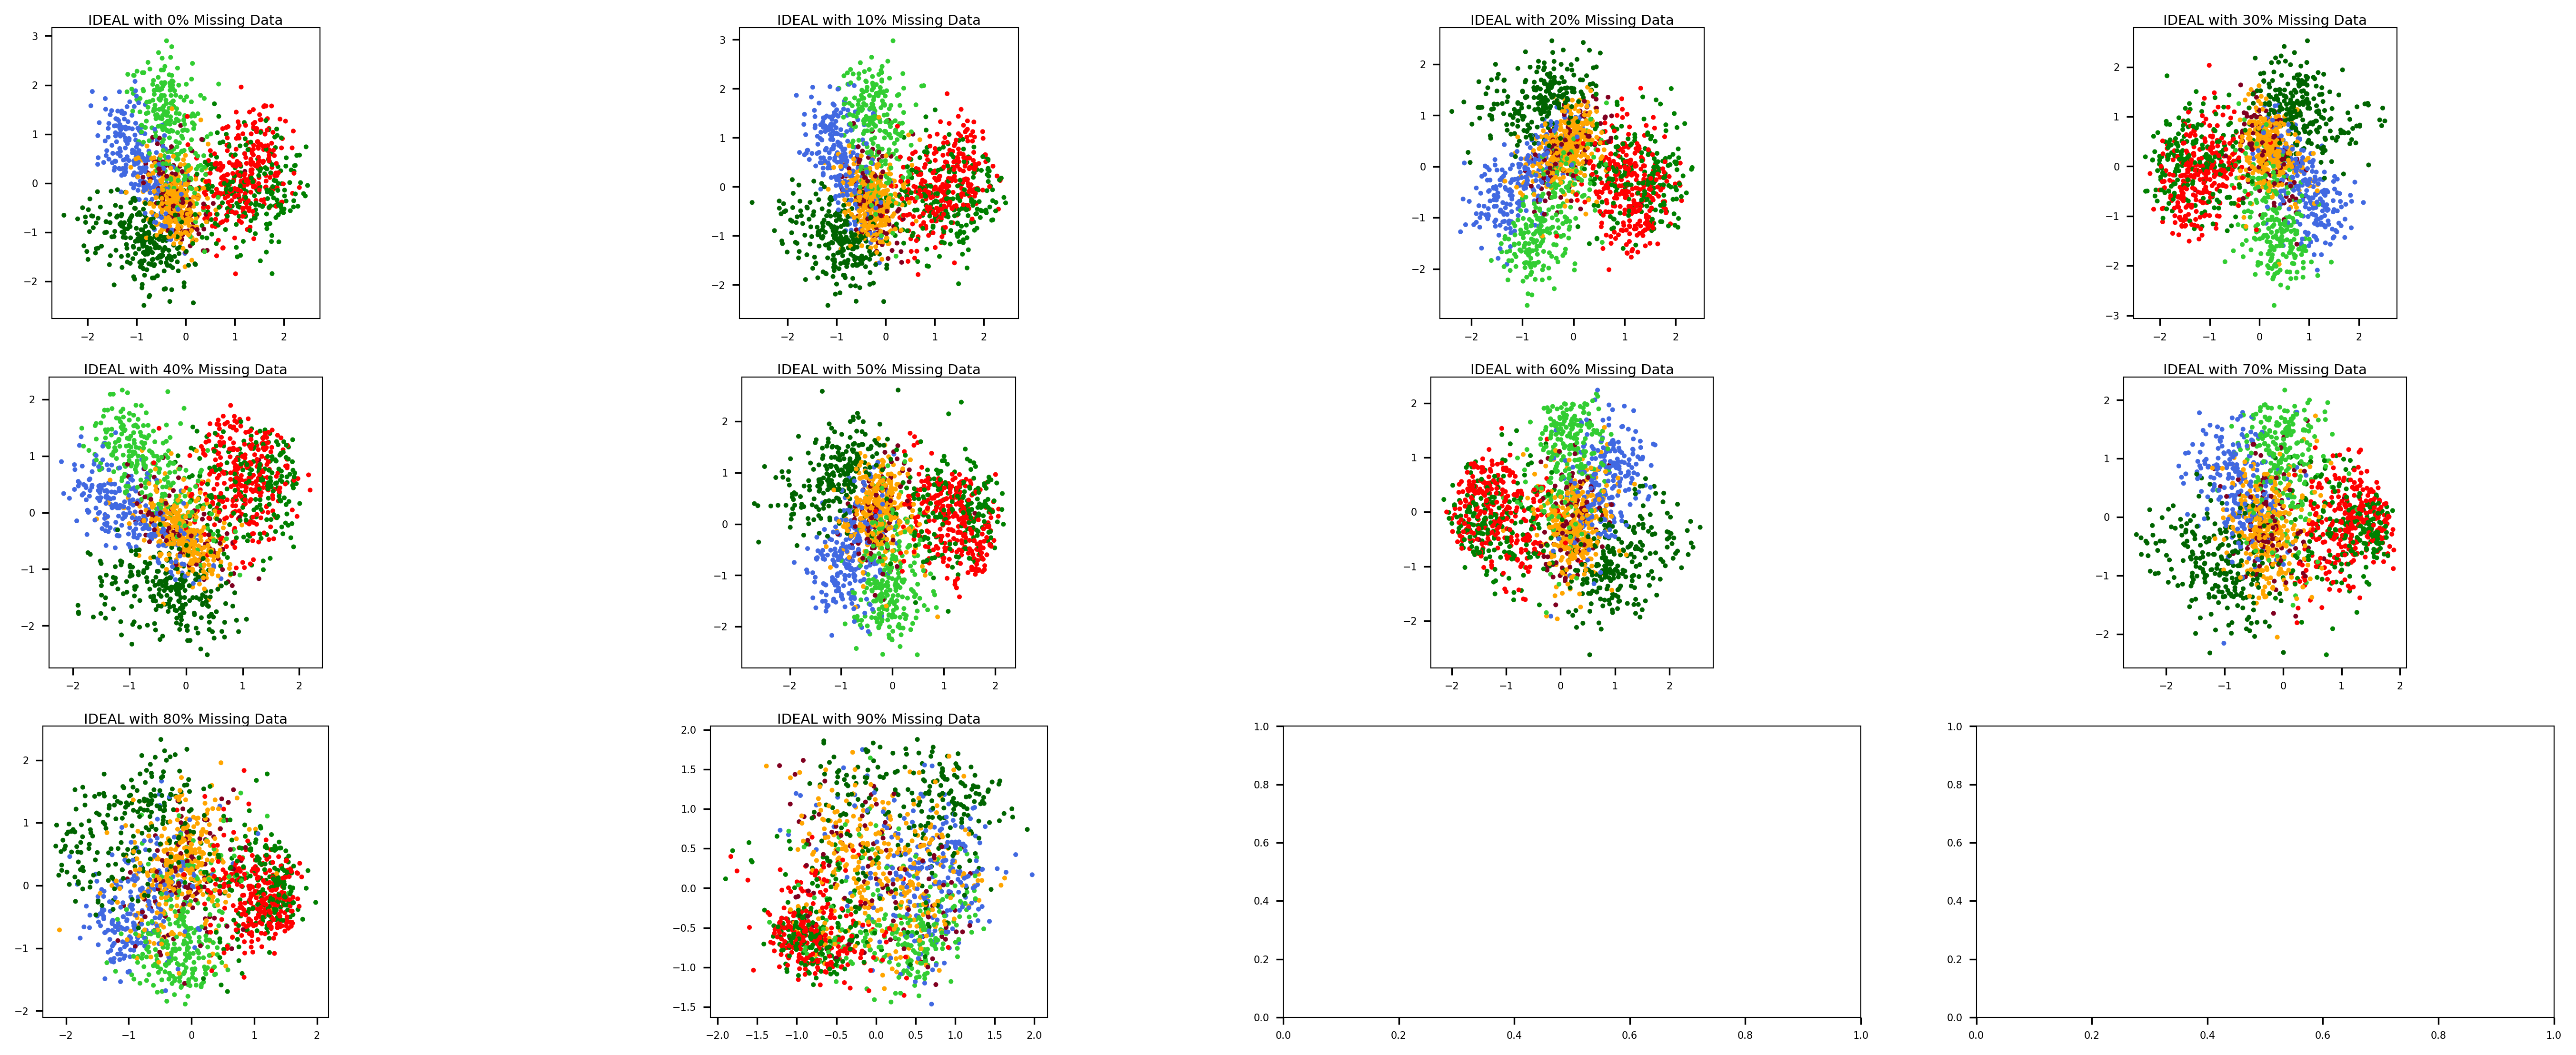

In [37]:
N = len(betabar.keys())
m,n = vis.get_rectangle(N)

# Create figure for subplots
fig, axes = plt.subplots(m, n, figsize=(6*n, 3*m))

for i, p in enumerate(sorted(betabar.keys())):
    ideal = IDEAL(betabar[p], xbar[p], index=train_reactions[p].index)
    ax = vis.plotEmbedding(ideal.train_embedding, ax=axes.flatten()[i], c=train_users['color'], s=2)   
    ax.set_title(f'IDEAL with {p}% Missing Data')

plt.show()

## Check Posterior

In [55]:
posterior_x = pd.read_csv(f'{output_path}/check posterior/x_0.csv',index_col=0)
posterior_xbar = pd.read_csv(f'{output_path}/check posterior/xbar_0.csv',index_col=0)
posterior_beta = pd.read_csv(f'{output_path}/check posterior/beta_0.csv',index_col=0)
posterior_betabar = pd.read_csv(f'{output_path}/check posterior/betabar_0.csv',index_col=0)

ideal = IDEAL(posterior_betabar, posterior_xbar, index=train_reactions[0].index, columns=train_reactions[0].columns)

In [61]:
fit_results = pd.DataFrame(train_reactions[0].progress_apply(ideal.encode, axis=1, result_type='expand').values,
                           index=train_reactions[p].index, 
                           columns=['coord1D', 'coord2D', 'loss fit'])

fit_predictions = ideal.predict(fit_results.iloc[:,:2].values)

_ = compute_metric(fit_predictions, train_reactions[0], train_reactions[p].isna())

  0%|          | 0/1622 [00:00<?, ?it/s]

 Fit Accuracy: 0.8393517703012154
 Fit RMSE: 0.33999863869183766
 Imputation Accuracy: 0.8332033799956481
 Imputation RMSE: 0.34224471088705116



In [99]:
def get_samples(n):
    i = ideal.train_embedding.index.get_loc(n)
    return posterior_x.loc[:,[f'Legislator.{i+1}.D1', f'Legislator.{i+1}.D2']].reset_index(drop=True)

fit_results['ideal fit'] = ideal.train_embedding.apply(lambda row: ideal.objective(row.values, train_reactions[0].loc[row.name])[0], axis=1)
fit_results['difference'] = np.abs(fit_results['ideal fit']- fit_results['fit'])
fit_results.sort_values('difference')

coord1D   coord2D        fit  ideal fit  difference
1315 -0.459530 -0.642116  13.097015  13.097058    0.000043
1854 -1.372356 -0.071083   9.598747   9.598799    0.000053
922  -0.729088  0.421534  13.252605  13.252667    0.000062
397  -0.816217 -1.189196  13.465321  13.465394    0.000073
991  -0.227952  1.232581   9.479014   9.479109    0.000095
...        ...       ...        ...        ...         ...
1042 -1.229714  1.807142  13.147822  14.060946    0.913124
1048 -1.063253  1.454101  12.167657  13.086935    0.919278
1338 -0.369084  0.250684  18.784634  19.911175    1.126541
1776  1.299255 -1.485429  10.243896  11.410118    1.166222
88    0.106844 -0.113464  15.877660  17.050490    1.172831

[1622 rows x 5 columns]

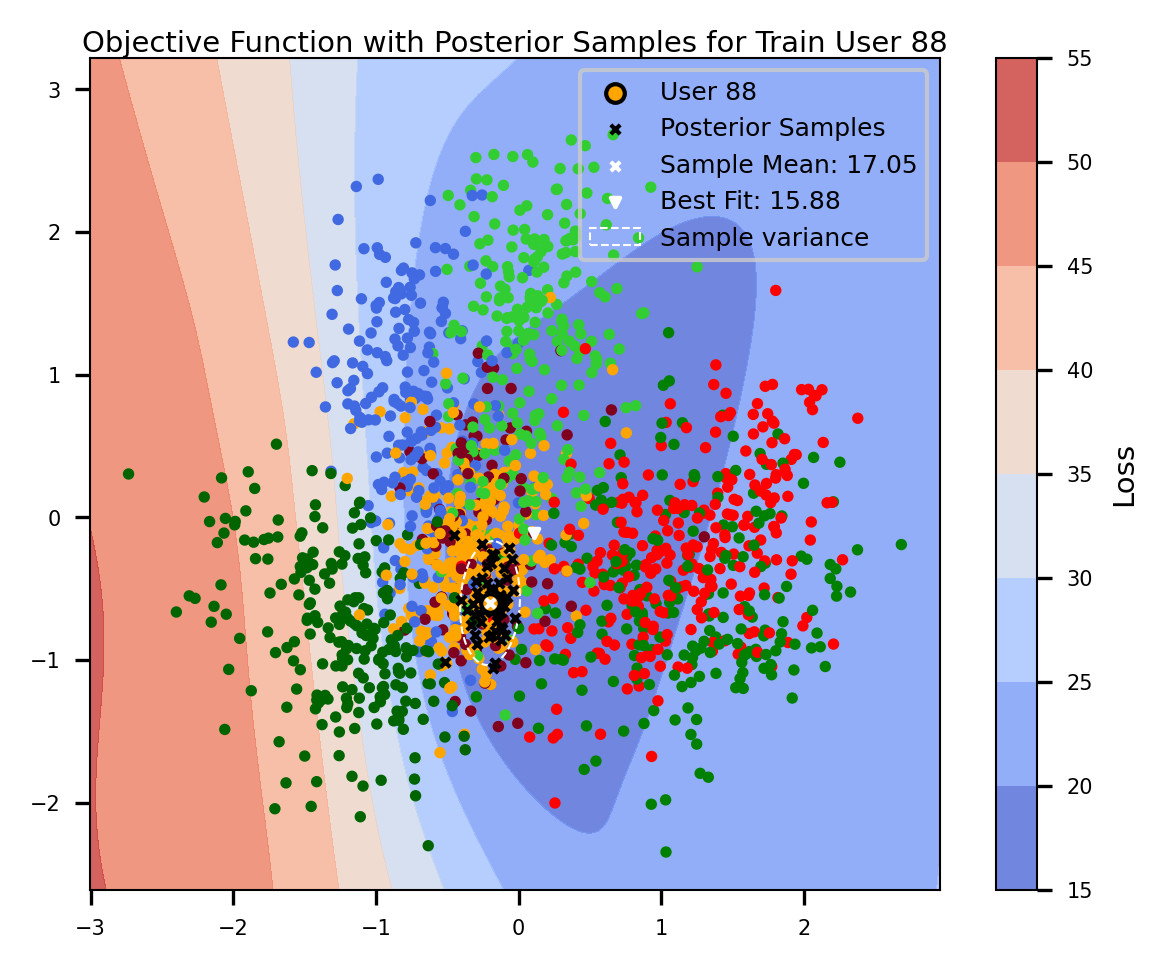

In [101]:
def plotPosterior(n, ax=None):
    samples = get_samples(n)

    if not ax:
        fig, ax = plt.subplots(figsize=(vis.textwidth,0.75*vis.textwidth))

    ax = vis.plotEmbedding(ideal.train_embedding, n=n, ax=ax, s=3, c=train_users['color'], zorder=2,
                            highlight={'s':20,'lw':1, 'color':train_users.loc[n, 'color'], 'zorder':4}) 
    ax = vis.plotEmbedding(samples, ax=ax, s=5, marker='x',c='black', zorder=3.5, label='Posterior Samples')            
    ax.set_title(f'Objective Function with Posterior Samples for Train User {n}')


    user = train_reactions[0].loc[n]
    answers = user.loc[~user.isna()]
    vis.plotObjective(ideal.objective, answers, r=200, ax=ax)

    G = WT.GaussianDistribution().estimate(samples.values)
    ax.scatter(G.mean[0],G.mean[1], c='white', marker='x', s=5, zorder=5, label=f'Sample Mean: {ideal.objective(G.mean, answers)[0].round(2)}')
    ax.scatter(fit_results.loc[n,'coord1D'],fit_results.loc[n,'coord2D'], 
               color='white', marker='v', s=5, zorder=5, label=f"Best Fit: {round(fit_results.loc[n, 'fit'],2)}")

    vis.plotGaussian(G, ax=ax, std=2, edgecolor='white', linewidth=.5,  zorder=3, label='Sample variance')

    # vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name])
    ax.legend()

plotPosterior(88)

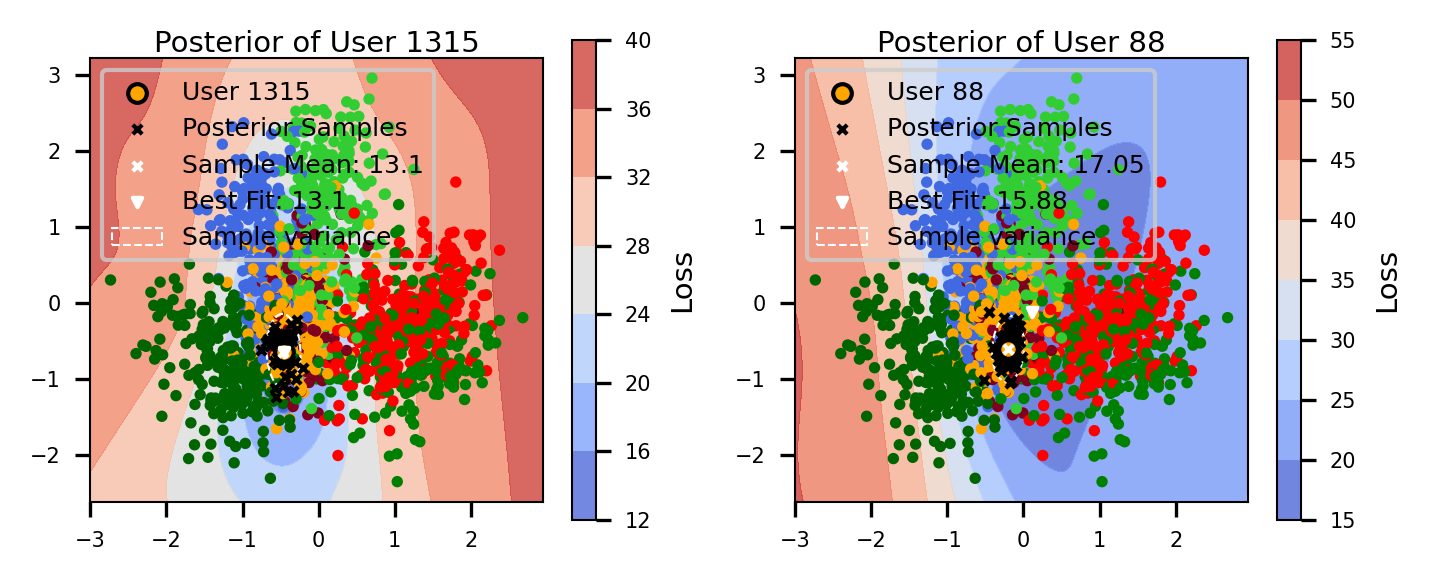

In [100]:
def UserPosteriors(n1, n2):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(vis.textwidth,0.4*vis.textwidth))
    plotPosterior(n1, ax=ax1)
    plotPosterior(n2, ax=ax2)
    ax1.set_title(f'Posterior of User {n1}')
    ax2.set_title(f'Posterior of User {n2}')
    fig.tight_layout()

UserPosteriors(1315,88)

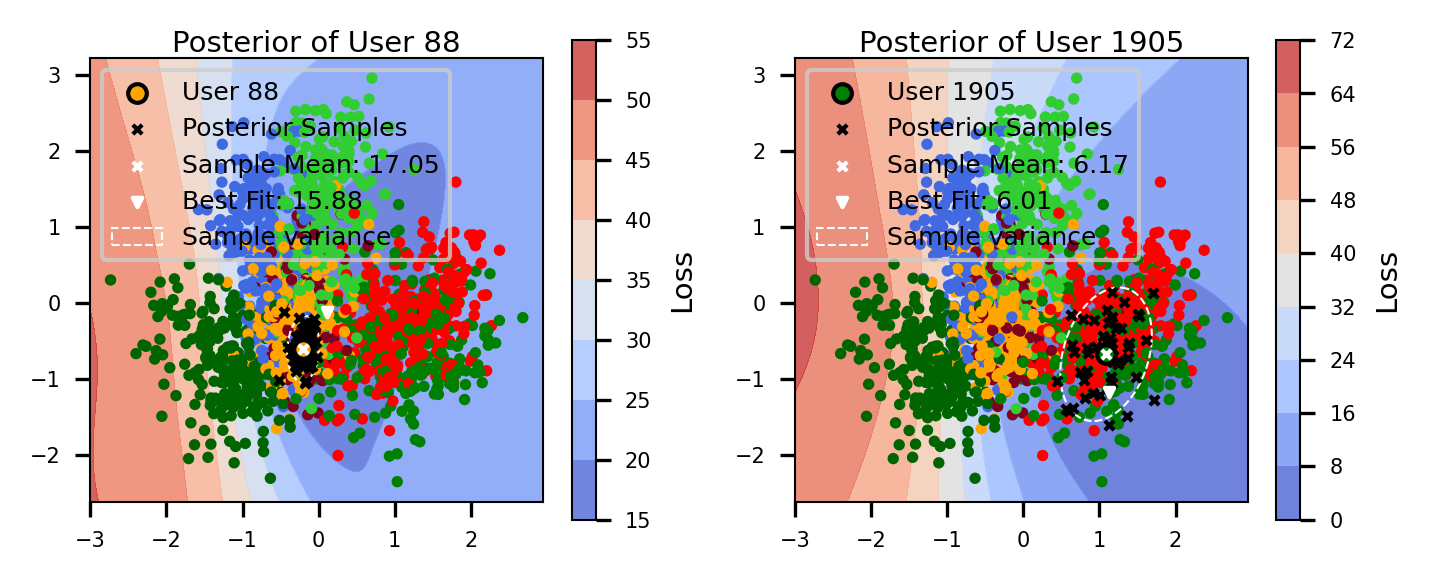

In [90]:
UserPosteriors(88, 1905)

0       [10.943772140292143]
1        [12.43310388383758]
2       [12.423365157857193]
3         [4.85639450905551]
4       [15.029815361886362]
                ...         
1905     [6.172709677958249]
1906     [4.776785412463887]
1907    [10.233015623436044]
1909     [15.27505799413324]
1910    [13.057195109368086]
Length: 1622, dtype: object

coord1D   coord2D        fit
0     0.377863 -0.150502  10.928232
1    -0.617716  0.285037  12.366281
2    -0.477664  0.121699  12.388605
3     1.034353 -0.721017   4.701976
4    -0.047135 -0.042841  14.999396
...        ...       ...        ...
1905  1.120530 -1.172715   6.010934
1906  1.802099 -1.919859   4.632502
1907  0.327687 -0.297079  10.101390
1909 -0.558500 -0.891113  15.272372
1910 -0.120257  0.590349  12.980257

[1622 rows x 3 columns]